In [1]:
%matplotlib inline

import ast
import os
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator
from matplotlib.ticker import ScalarFormatter
from matplotlib.patches import Patch
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Arial'

from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as ticker
import matplotlib
import seaborn as sns
from itertools import groupby
from scipy import integrate
from tqdm import tqdm

plt.style.use('ggplot')
pd.set_option('chained_assignment',None)

sys.path.append(os.path.join( '..'))
from miriam_py.utils import load_config
data_path = load_config()['paths']['data']

In [2]:
def sum_tuples(l):
    return tuple(sum(x) for x in zip(*l))

def calc_risk_total(x,hazard,RPS,events):
    collect_risks = []
    for y in range(7):
        collect_risks.append(integrate.simps([x[y] for x in x[events]][::-1], x=RPS[::-1]))
    return collect_risks

def set_prot_standard(x,prot_lookup,events):
    prot_stand = prot_lookup[x.region]
    no_floods= [z for z in events if prot_stand > int(z.split('-')[1])]
    for no_flood in no_floods:
        x[no_flood] = (0,0,0,0,0,0,0)
    return x

def pluvial_design(x,hazard):
    if x.GroupCode == 'HIC':
        if x.road_type in ['primary','secondary']:
            if hazard == 'PU':
                x[['PU-5','PU-10','PU-20','PU-50']] = [(0,0,0,0,0,0,0)]*4
            elif hazard == 'FU':
                x[['FU-5','FU-10','FU-20','FU-50']] = [(0,0,0,0,0,0,0)]*4
            elif hazard == 'CF':
                x[['CF-10','CF-20','CF-50']] = [(0,0,0,0,0,0,0)]*3               
        else:
            if hazard == 'PU':
                x[['PU-5','PU-10','PU-20']] = [(0,0,0,0,0,0,0)]*3
            elif hazard == 'FU':
                x[['FU-5','FU-10','FU-20']] = [(0,0,0,0,0,0,0)]*3
            elif hazard == 'CF':
                x[['CF-10','CF-20']] = [(0,0,0,0,0,0,0)]*2
    elif x.GroupCode == 'UMC':
        if x.road_type in ['primary','secondary']:
            if hazard == 'PU':
                x[['PU-5','PU-10','PU-20']] = [(0,0,0,0,0,0,0)]*3
            elif hazard == 'FU':
                x[['FU-5','FU-10','FU-20']] = [(0,0,0,0,0,0,0)]*3
            elif hazard == 'CF':
                x[['CF-10','CF-20']] = [(0,0,0,0,0,0,0)]*2
        else:
            if hazard == 'PU':
                x[['PU-5','PU-10']] = [(0,0,0,0,0,0,0)]*2
            elif hazard == 'FU':
                x[['FU-5','FU-10']] = [(0,0,0,0,0,0,0)]*2
            elif hazard == 'CF':
                x[['CF-10']] = [(0,0,0,0,0,0,0)]*1
    else:
        if x.road_type in ['primary','secondary']:
            if hazard == 'PU':
                x[['PU-5','PU-10']] = [(0,0,0,0,0,0,0)]*2
            elif hazard == 'FU':
                x[['FU-5','FU-10']] = [(0,0,0,0,0,0,0)]*2
            elif hazard == 'CF':
                x[['CF-10']] = [(0,0,0,0,0,0,0)]*1
       
    return x

def pluvial_design_rail(x,hazard):
    if (hazard == 'PU'):
        if  x.GroupCode == 'HIC':
            x[['PU-5','PU-10','PU-20','PU-50']] = [(0,0,0,0,0,0,0)]*4
        elif x.GroupCode == 'UMC':
            x[['PU-5','PU-10','PU-20','PU-50']] = [(0,0,0,0,0,0,0)]*4
        else:
            x[['PU-5','PU-10','PU-20']] =[(0,0,0,0,0,0,0)]*3

    if (hazard == 'FU'):
        if  x.GroupCode == 'HIC':
            x[['FU-5','FU-10','FU-20','FU-50']] = [(0,0,0,0,0,0,0)]*4
        elif x.GroupCode == 'UMC':
            x[['FU-5','FU-10','FU-20','FU-50']] = [(0,0,0,0,0,0,0)]*4
        else:
            x[['FU-5','FU-10','FU-20']] = [(0,0,0,0,0,0,0)]*3


    if (hazard == 'CF'):
        if  x.GroupCode == 'HIC':
            x[['CF-10','CF-20','CF-50',]] =[(0,0,0,0,0,0,0)]*3
        elif x.GroupCode == 'UMC':
            x[['CF-10','CF-20','CF-50']] = [(0,0,0,0,0,0,0)]*3
        else:
            x[['CF-10','CF-20']] = [(0,0,0,0,0,0,0)]*2

    return x

def get_value(x,ne_sindex,ne_countries,col):
    matches = ne_countries.loc[ne_sindex.intersection(x.centroid.bounds[:2])]
    
    for match in matches.iterrows():
        if match[1].geometry.intersects(x) == True:
            return match[1][col]

In [3]:
%%time
global_countries = gpd.read_file(os.path.join(data_path,'input_data','global_countries.shp'))
global_regions = gpd.read_file(os.path.join(data_path,'input_data','global_regions_v2.shp'))
prot_lookup = dict(zip(global_regions['GID_2'],global_regions['prot_stand']))
ne_countries = gpd.read_file(os.path.join(data_path,'input_data','ne_50m_admin_0_countries.shp'))
ne_sindex = ne_countries.sindex

incomegroups = pd.read_csv(os.path.join(data_path,'input_data','incomegroups_2018.csv'),index_col=[0])
global_countries['GDP'] = global_countries.geometry.apply(lambda x: get_value(x,ne_sindex,ne_countries,'GDP_MD_EST'))
global_countries['POP'] = global_countries.geometry.apply(lambda x: get_value(x,ne_sindex,ne_countries,'POP_EST'))

rail_to_remove =['disused','abandoned','dismantled','preserved', 'proposed','razed', 
                 'planned','no','historical','na','not_built','abandonned', 'uncompleted', 'demolished',
                 'abandoned_tram','construction;rail', 'rail;construction','waste_disposal','collapsed']

Wall time: 6.4 s


In [4]:
%%time
events_FU = ['FU-5', 'FU-10', 'FU-20', 'FU-50', 'FU-75', 'FU-100', 'FU-200', 'FU-250','FU-500', 'FU-1000']
tot_road_FU = pd.read_csv(os.path.join(data_path,'summarized','FU_road_losses.csv'),
                          converters = dict(zip(events_FU,[ast.literal_eval]*len(events_FU))),index_col=[0]) 
tot_rail_FU = pd.read_csv(os.path.join(data_path,'summarized','FU_rail_losses.csv'),
                          converters = dict(zip(events_FU,[ast.literal_eval]*len(events_FU))),index_col=[0]) 
print('FU loaded')

events_PU = ['PU-5', 'PU-10', 'PU-20', 'PU-50', 'PU-75', 'PU-100', 'PU-200', 'PU-250', 'PU-500', 'PU-1000']
tot_road_PU = pd.read_csv(os.path.join(data_path,'summarized','PU_road_losses.csv'),
                          converters = dict(zip(events_PU,[ast.literal_eval]*len(events_PU))),index_col=[0]) 
tot_rail_PU = pd.read_csv(os.path.join(data_path,'summarized','PU_rail_losses.csv'),
                          converters = dict(zip(events_PU,[ast.literal_eval]*len(events_PU))),index_col=[0]) 
print('PU loaded')

events_EQ = ['EQ_rp250','EQ_rp475','EQ_rp975','EQ_rp1500','EQ_rp2475'] 
tot_road_EQ = pd.read_csv(os.path.join(data_path,'summarized','EQ_road_losses.csv'),
                          converters = dict(zip(events_EQ,[ast.literal_eval]*len(events_EQ))),index_col=[0]) 
tot_rail_EQ = pd.read_csv(os.path.join(data_path,'summarized','EQ_rail_losses.csv'),
                          converters = dict(zip(events_EQ,[ast.literal_eval]*len(events_EQ))),index_col=[0]) 
print('EQ loaded')

events_Cyc = ['Cyc_rp50','Cyc_rp100','Cyc_rp250','Cyc_rp500','Cyc_rp1000']
tot_road_Cyc = pd.read_csv(os.path.join(data_path,'summarized','Cyc_road_losses_uncer.csv'),
                           converters = dict(zip(events_Cyc,[ast.literal_eval]*len(events_Cyc))))
tot_rail_Cyc = pd.read_csv(os.path.join(data_path,'summarized','Cyc_rail_losses.csv'),
                           converters = dict(zip(events_Cyc,[ast.literal_eval]*len(events_Cyc))))
print('Cyc loaded')

events_CF = ['CF-10', 'CF-20', 'CF-50', 'CF-100', 'CF-200', 'CF-500', 'CF-1000']
tot_road_CF = pd.read_csv(os.path.join(data_path,'summarized','CF_road_losses.csv'),
                          converters = dict(zip(events_CF,[ast.literal_eval]*len(events_CF))),index_col=[0])
tot_rail_CF = pd.read_csv(os.path.join(data_path,'summarized','CF_rail_losses.csv'),
                          converters = dict(zip(events_CF,[ast.literal_eval]*len(events_CF))),index_col=[0])

print('CF loaded')

FU loaded
PU loaded
EQ loaded
Cyc loaded
CF loaded
Wall time: 1min 8s


In [5]:
%%time
tot_bridge_road = pd.read_csv(os.path.join(data_path,'summarized','bridge_road_risk_.csv'),index_col=[0],
                              converters = dict(zip(['CF_risk','Cyc_risk','EQ_risk','FU_risk','PU_risk'],[ast.literal_eval]*5)))

tot_bridge_road.IncomeGroup = tot_bridge_road.IncomeGroup.apply(lambda x :x.upper())
tot_bridge_rail = pd.read_csv(os.path.join(data_path,'summarized','bridge_rail_risk_.csv'),
                          converters = dict(zip(['CF_risk','Cyc_risk','EQ_risk','FU_risk','PU_risk'],[ast.literal_eval]*len(['CF_risk','Cyc_risk','EQ_risk','FU_risk','PU_risk']))),index_col=[0])

tot_bridge_rail.IncomeGroup = tot_bridge_rail.IncomeGroup.apply(lambda x :x.upper())

country_road_bridge = tot_bridge_road.loc[tot_bridge_road.road_type.isin(['primary','secondary','tertiary'])].groupby(
    ['country'])['CF_risk','Cyc_risk','EQ_risk','FU_risk','PU_risk'].agg(sum_tuples)

country_rail_bridge = tot_bridge_rail.groupby(['country'])['CF_risk','Cyc_risk','EQ_risk','FU_risk','PU_risk'].agg(sum_tuples)
                          

Wall time: 10.1 s


In [6]:
tot_road_FU = tot_road_FU.merge(incomegroups,left_on='country',right_on='CountryCode').merge(global_countries[['ISO_3digit','wbregion']],left_on='country',right_on='ISO_3digit')
tot_road_PU = tot_road_PU.merge(incomegroups,left_on='country',right_on='CountryCode').merge(global_countries[['ISO_3digit','wbregion']],left_on='country',right_on='ISO_3digit')
tot_road_Cyc = tot_road_Cyc.merge(incomegroups,left_on='country',right_on='CountryCode')
tot_road_EQ = tot_road_EQ.merge(incomegroups,left_on='country',right_on='CountryCode')
tot_road_CF = tot_road_CF.merge(incomegroups,left_on='country',right_on='CountryCode')

tot_rail_FU = tot_rail_FU.merge(incomegroups,left_on='country',right_on='CountryCode').merge(global_countries[['ISO_3digit','wbregion']],left_on='country',right_on='ISO_3digit')
tot_rail_PU = tot_rail_PU.merge(incomegroups,left_on='country',right_on='CountryCode').merge(global_countries[['ISO_3digit','wbregion']],left_on='country',right_on='ISO_3digit')
tot_rail_Cyc = tot_rail_Cyc.merge(incomegroups,left_on='country',right_on='CountryCode')
tot_rail_EQ = tot_rail_EQ.merge(incomegroups,left_on='country',right_on='CountryCode')
tot_rail_CF = tot_rail_CF.merge(incomegroups,left_on='country',right_on='CountryCode')

In [7]:
%%time
tqdm.pandas()
tot_road_FU = tot_road_FU.progress_apply(lambda x : set_prot_standard(x,prot_lookup,events_FU),axis=1)
tot_road_CF = tot_road_CF.progress_apply(lambda x : set_prot_standard(x,prot_lookup,events_CF),axis=1)

tot_rail_FU = tot_rail_FU.progress_apply(lambda x : set_prot_standard(x,prot_lookup,events_FU),axis=1)
tot_rail_CF = tot_rail_CF.progress_apply(lambda x : set_prot_standard(x,prot_lookup,events_CF),axis=1)

tot_road_FU = tot_road_FU.progress_apply(lambda x : pluvial_design(x,'FU'),axis=1)
tot_road_CF = tot_road_CF.progress_apply(lambda x : pluvial_design(x,'CF'),axis=1)
tot_road_PU = tot_road_PU.progress_apply(lambda x : pluvial_design(x,'PU'),axis=1)
tot_rail_FU = tot_rail_FU.progress_apply(lambda x : pluvial_design_rail(x,'FU'),axis=1)
tot_rail_CF = tot_rail_CF.progress_apply(lambda x : pluvial_design_rail(x,'CF'),axis=1)
tot_rail_PU = tot_rail_PU.progress_apply(lambda x : pluvial_design_rail(x,'PU'),axis=1)

100%|██████████████████████████████████████████████████████████████████████████| 40907/40907 [00:17<00:00, 2403.32it/s]


Wall time: 2min 56s


In [8]:
%%time
FU_country_stats = tot_road_FU.loc[tot_road_FU.road_type.isin(['primary','secondary','tertiary'])]
FU_country_stats = FU_country_stats.groupby(['country'])[events_FU].agg(sum_tuples)

PU_country_stats = tot_road_PU.loc[tot_road_PU.road_type.isin(['primary','secondary','tertiary'])]
PU_country_stats = PU_country_stats.groupby(['country'])[events_PU].agg(sum_tuples)

CF_country_stats = tot_road_CF.loc[tot_road_CF.road_type.isin(['primary','secondary','tertiary'])]
CF_country_stats = CF_country_stats.groupby(['country'])[events_CF].agg(sum_tuples)

EQ_country_stats = tot_road_EQ.loc[tot_road_EQ.road_type.isin(['primary','secondary','tertiary'])]
EQ_country_stats = EQ_country_stats.groupby(['country'])[events_EQ].agg(sum_tuples)

Cyc_country_stats = tot_road_Cyc.loc[tot_road_Cyc.road_type.isin(['primary','secondary','tertiary'])]
Cyc_country_stats = Cyc_country_stats.groupby(['country'])[events_Cyc].agg(sum_tuples)

Wall time: 1.67 s


In [9]:
FU_country_stats_rail = tot_rail_FU.loc[~(tot_rail_FU.infra_type.isin(rail_to_remove))].groupby(
    ['country'])[events_FU].agg(sum_tuples)
PU_country_stats_rail = tot_rail_PU.loc[~(tot_rail_PU.infra_type.isin(rail_to_remove))].groupby(
    ['country'])[events_PU].agg(sum_tuples)
Cyc_country_stats_rail = tot_rail_Cyc.loc[~(tot_rail_Cyc.infra_type.isin(rail_to_remove))].groupby(
    ['country'])[events_Cyc].agg(sum_tuples)
EQ_country_stats_rail = tot_rail_EQ.loc[~(tot_rail_EQ.infra_type.isin(rail_to_remove))].groupby(
    ['country'])[events_EQ].agg(sum_tuples)
CF_country_stats_rail = tot_rail_CF.loc[~(tot_rail_CF.infra_type.isin(rail_to_remove))].groupby(
    ['country'])[events_CF].agg(sum_tuples)

In [10]:
%%time
tqdm.pandas()
RPS = [1/5,1/10,1/20,1/50,1/75,1/100,1/200,1/250,1/500,1/1000]
country_risk_PU_road = pd.DataFrame(PU_country_stats.progress_apply(lambda x: calc_risk_total(x,'PU',RPS,events_PU),axis=1).tolist(),index=PU_country_stats.index,
     columns=['perc_0','perc_20','perc_40','perc_50','perc_60','perc_80','perc_100'])
country_risk_FU_road = pd.DataFrame(FU_country_stats.progress_apply(lambda x: calc_risk_total(x,'FU',RPS,events_FU),axis=1).tolist(),index=FU_country_stats.index,
     columns=['perc_0','perc_20','perc_40','perc_50','perc_60','perc_80','perc_100'])
country_risk_PU_rail = pd.DataFrame(PU_country_stats_rail.progress_apply(lambda x: calc_risk_total(x,'PU',RPS,events_PU),axis=1).tolist(),
                                    index=PU_country_stats_rail.index,
     columns=['perc_0','perc_20','perc_40','perc_50','perc_60','perc_80','perc_100'])
country_risk_FU_rail = pd.DataFrame(FU_country_stats_rail.progress_apply(lambda x: calc_risk_total(x,'FU',RPS,events_FU),axis=1).tolist(),
                                    index=FU_country_stats_rail.index,
     columns=['perc_0','perc_20','perc_40','perc_50','perc_60','perc_80','perc_100'])

RPS = [1/10,1/20,1/50,1/100,1/200,1/500,1/1000]
country_risk_CF_road = pd.DataFrame(CF_country_stats.progress_apply(lambda x: calc_risk_total(x,'CF',RPS,events_CF),axis=1).tolist(),
                       index=CF_country_stats.index,
     columns=['perc_0','perc_20','perc_40','perc_50','perc_60','perc_80','perc_100'])
country_risk_CF_rail = pd.DataFrame(CF_country_stats_rail.progress_apply(lambda x: calc_risk_total(x,'CF',RPS,events_CF),axis=1).tolist(),
                       index=CF_country_stats_rail.index,
     columns=['perc_0','perc_20','perc_40','perc_50','perc_60','perc_80','perc_100'])

RPS = [1/50,1/100,1/250,1/500,1/1000]
country_risk_EQ_road = pd.DataFrame(EQ_country_stats.progress_apply(lambda x: calc_risk_total(x,'EQ',RPS,events_EQ),axis=1).tolist(),
                       index=EQ_country_stats.index,
     columns=['perc_0','perc_20','perc_40','perc_50','perc_60','perc_80','perc_100'])
country_risk_EQ_rail = pd.DataFrame(EQ_country_stats_rail.progress_apply(lambda x: calc_risk_total(x,'EQ',RPS,events_EQ),axis=1).tolist(),
                       index=EQ_country_stats_rail.index,
     columns=['perc_0','perc_20','perc_40','perc_50','perc_60','perc_80','perc_100'])

RPS = [1/250,1/475,1/975,1/1500,1/2475]
country_risk_Cyc_road = pd.DataFrame(Cyc_country_stats.progress_apply(lambda x: calc_risk_total(x,'Cyc',RPS,events_Cyc),axis=1).tolist(),
                       index=Cyc_country_stats.index,
     columns=['perc_0','perc_20','perc_40','perc_50','perc_60','perc_80','perc_100'])
country_risk_Cyc_rail = pd.DataFrame(Cyc_country_stats_rail.progress_apply(lambda x: calc_risk_total(x,'Cyc',RPS,events_Cyc),axis=1).tolist(),
                       index=Cyc_country_stats_rail.index,
     columns=['perc_0','perc_20','perc_40','perc_50','perc_60','perc_80','perc_100'])

100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 218.64it/s]


Wall time: 6.11 s


In [11]:
tot_roads = pd.read_feather(os.path.join(data_path,'summarized','all_road_stats.ft'))
tot_roads = tot_roads.loc[tot_roads.road_type.isin(['primary','secondary','tertiary'])]
tot_roads = tot_roads.merge(global_countries[['ISO_3digit','wbincomena']],left_on='country',right_on='ISO_3digit')
tot_roads = tot_roads.merge(incomegroups,left_on='country',right_on='CountryCode')
tot_len_road = pd.DataFrame(tot_roads.groupby('country')['length'].sum(),columns=['length'])
lookup_length_road = dict(zip(tot_len_road.index,tot_len_road.length))

In [12]:
tot_rail = pd.read_feather(os.path.join(data_path,'summarized','all_railway_stats.ft'))
tot_rail = tot_rail.loc[~(tot_rail.infra_type.isin(rail_to_remove))]

tot_rail = tot_rail.merge(global_countries[['ISO_3digit','wbincomena']],left_on='country',right_on='ISO_3digit')
tot_rail = tot_rail.merge(incomegroups,left_on='country',right_on='CountryCode')
tot_len_rail = pd.DataFrame(tot_rail.groupby('country')['length'].sum(),columns=['length'])

tot_len = tot_len_road.add(tot_len_rail, fill_value=0)
lookup_length = dict(zip(tot_len.index,tot_len.length))

In [13]:
def gdp_lookup(x):
    try:
        return GDP_lookup[x]
    except:
        return 0

In [14]:
country_br_ro = (pd.DataFrame(country_road_bridge['Cyc_risk'].apply(pd.Series)).add(
pd.DataFrame(country_road_bridge['EQ_risk'].apply(pd.Series)), fill_value=0).add(
pd.DataFrame(country_road_bridge['PU_risk'].apply(pd.Series)), fill_value=0).add(
pd.DataFrame(country_road_bridge['FU_risk'].apply(pd.Series)), fill_value=0).add(
pd.DataFrame(country_road_bridge['CF_risk'].apply(pd.Series)), fill_value=0))

country_br_ro.columns = ['perc_0','perc_20','perc_40','perc_50','perc_60','perc_80','perc_100']

country_br_ra = (pd.DataFrame(country_rail_bridge['Cyc_risk'].apply(pd.Series)).add(
pd.DataFrame(country_rail_bridge['EQ_risk'].apply(pd.Series)), fill_value=0).add(
pd.DataFrame(country_rail_bridge['PU_risk'].apply(pd.Series)), fill_value=0).add(
pd.DataFrame(country_rail_bridge['FU_risk'].apply(pd.Series)), fill_value=0).add(
pd.DataFrame(country_rail_bridge['CF_risk'].apply(pd.Series)), fill_value=0))

country_br_ra.columns = ['perc_0','perc_20','perc_40','perc_50','perc_60','perc_80','perc_100']

In [39]:
gdp_country = pd.read_csv(os.path.join(data_path,'input_data','gdp_country.csv'),encoding='iso-8859-1').fillna(0)
GDP_lookup = dict(zip(gdp_country['Country Code'],gdp_country.max(axis=1)))
GDP_lookup_2 = dict(zip(global_countries['GID_0'],global_countries.GDP))

country_risk = country_risk_PU_road.add(country_risk_FU_road, fill_value=0).add(
    country_risk_CF_road, fill_value=0).add(country_risk_EQ_road, fill_value=0).add(country_risk_Cyc_road, fill_value=0).add(
    country_risk_FU_rail, fill_value=0).add(country_risk_CF_rail, fill_value=0).add(country_risk_EQ_rail, fill_value=0).add(
    country_risk_PU_rail, fill_value=0).add(country_risk_Cyc_rail, fill_value=0).add(country_br_ro, fill_value=0).add(
    country_br_ra, fill_value=0)

country_risk = country_risk.loc[country_risk.perc_50 != 0]

country_risk = country_risk.reset_index()
country_risk['GDP'] = country_risk.country.apply(lambda x: gdp_lookup(x))
country_risk['length'] = country_risk.country.apply(lambda x: lookup_length[x])

country_risk = country_risk.loc[country_risk.perc_50 != 0]
country_risk = country_risk.loc[country_risk.GDP != 0]
country_risk.dropna(inplace=True)

In [40]:
total_infra_value = pd.read_csv(os.path.join(data_path,'summarized','total_infrastructure_values.csv'))
country_infra_value = total_infra_value.groupby(['country']).sum()

In [41]:
name_lookup = dict(zip(global_countries['GID_0'],global_countries['NAME_0']))
inc_lookup = dict(zip(incomegroups['CountryCode'],incomegroups['GroupCode'].apply(lambda x: x.upper())))

color_scheme = ['#F3FFBD','#B2DBBF','#70C1B3','#247BA0'] #['#bae4bc','#7bccc4','#43a2ca','#0868ac']
income_dict = ['LIC', 'LMC', 'UMC', 'HIC']
color_lookup = dict(zip(income_dict,color_scheme))

In [42]:
country_risk['wbinc'] = country_risk['country'].apply(lambda x : inc_lookup[x])

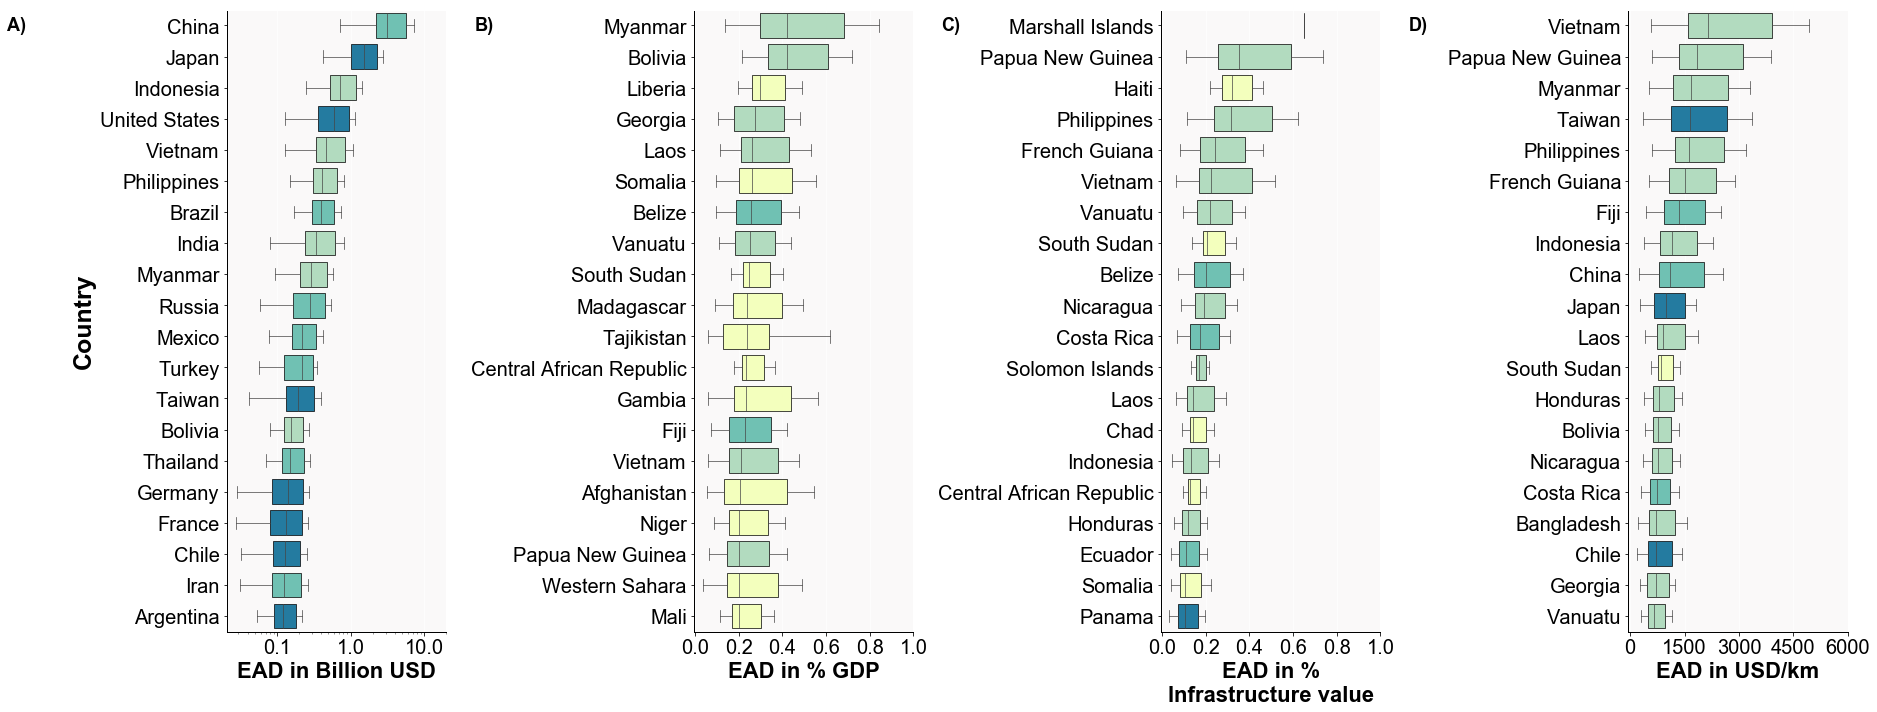

In [44]:
fig, axes = plt.subplots(1, 4,figsize=(26,10))  
fig.subplots_adjust(wspace=1)
letters = ['A','B','C','D']

for iter_,ax in enumerate(axes.flat):
    if iter_ == 0:
        top20 = country_risk.sort_values('perc_50',
                                 ascending=False)[['country','perc_0','perc_20','perc_40',
                                                   'perc_50','perc_60','perc_80','perc_100']][:20].groupby('country').sum().sort_values('perc_50',ascending=False)
        top20 = pd.DataFrame(pd.DataFrame(top20.unstack(),columns=['Value']).reset_index(),columns=['level_0','country','Value'])

        top20['Value'] = top20['Value']/1e9
        top20['wbinc'] = top20['country'].apply(lambda x : inc_lookup[x])
        top20['color'] = top20['wbinc'].apply(lambda x : color_lookup[x])
        top20['country'] = top20['country'].apply(lambda x : name_lookup[x])
        sns.boxplot(x=top20.Value,y=top20.country, showfliers=False,ax=ax,linewidth = 0.7)

        ax.xaxis.set_ticks(np.arange(0,20.1,4))
        ax.set_xlabel(xlabel='EAD in Billion USD',fontweight="bold",color='black',fontsize=22) 
        ax.set_ylabel(ylabel='Country',fontweight="bold",color='black',fontsize=25) #
        ax.set_facecolor('#FAF9F9')
        ax.spines['left'].set_color('black')
        ax.spines['bottom'].set_color('black')        
        ax.set_xscale("log", nonposx='clip')
        ax.set_xlim(right=20)
        ax.xaxis.set_major_formatter(ScalarFormatter())
        
        for y in range(20):
            ax.findobj(matplotlib.patches.Patch)[y].set_facecolor(top20.iloc[y]['color'])
            ax.findobj(matplotlib.patches.Patch)[y].set_edgecolor('black')
            
    
    elif iter_ == 1:
        country_risk_gdp = country_risk.copy()
        country_risk_gdp[['perc_0','perc_20','perc_40',
                          'perc_50','perc_60','perc_80','perc_100']] = country_risk_gdp[['perc_0',
                                                                                         'perc_20','perc_40','perc_50','perc_60','perc_80','perc_100']].div(country_risk.GDP, axis=0)

        top20 = country_risk_gdp.sort_values('perc_50',
                                 ascending=False)[['country','perc_0','perc_20','perc_40',
                                                   'perc_50','perc_60','perc_80','perc_100']][:20].groupby('country').sum().sort_values('perc_50',ascending=False)
        top20 = pd.DataFrame(pd.DataFrame(top20.unstack(),columns=['Value']).reset_index(),columns=['level_0','country','Value'])

        top20['Value'] = top20['Value']*100
        top20['wbinc'] = top20['country'].apply(lambda x : inc_lookup[x])
        top20['color'] = top20['wbinc'].apply(lambda x : color_lookup[x])
        top20['country'] = top20['country'].apply(lambda x : name_lookup[x])

        sns.boxplot(x=top20.Value,y=top20.country, showfliers=False,ax=ax,linewidth = 0.7)

        ax.xaxis.set_ticks(np.arange(0,1.1,0.2))
        ax.set_xlabel(xlabel='EAD in % GDP',fontweight="bold",color='black',fontsize=22) 
        ax.set_ylabel(ylabel='') #
        ax.set_facecolor('#FAF9F9')
        ax.spines['left'].set_color('black')
        ax.spines['bottom'].set_color('black')
        for y in range(20):
            ax.findobj(matplotlib.patches.Patch)[y].set_facecolor(top20.iloc[y]['color'])
            ax.findobj(matplotlib.patches.Patch)[y].set_edgecolor('black')
    elif iter_ == 2:

        country_risk_val = country_risk.copy()
        #country_risk_val = country_risk_val.loc[country_risk_val.country != 'MHL']
        country_risk_val = country_risk_val.groupby('country').sum()*100
        country_risk_val[['perc_0','perc_20','perc_40',
                          'perc_50','perc_60','perc_80','perc_100']] = country_risk_val[['perc_0',
                                                                                         'perc_20','perc_40','perc_50','perc_60','perc_80','perc_100']].div(country_infra_value.infra_value, axis=0)
        country_risk_val.reset_index(inplace=True)
        top20 = country_risk_val.sort_values('perc_50',
                                 ascending=False)[['country','perc_0','perc_20','perc_40',
                                                   'perc_50','perc_60','perc_80','perc_100']][0:20].groupby('country').sum().sort_values('perc_50',ascending=False)
        top20 = pd.DataFrame(pd.DataFrame(top20.unstack(),columns=['Value']).reset_index(),columns=['level_0','country','Value'])

        top20['Value'] = top20['Value']
        top20['wbinc'] = top20['country'].apply(lambda x : inc_lookup[x])
        top20['color'] = top20['wbinc'].apply(lambda x : color_lookup[x])
        top20['country'] = top20['country'].apply(lambda x : name_lookup[x])

        sns.boxplot(x=top20.Value,y=top20.country, showfliers=False,ax=ax,linewidth = 0.7)
        ax.set_facecolor('#FAF9F9')

        ax.set_xlabel(xlabel='EAD in %\nInfrastructure value',fontweight="bold",color='black',fontsize=22) 
        ax.set_ylabel(ylabel='') #
        ax.xaxis.set_ticks(np.arange(0,1.1,0.2))

        ax.spines['left'].set_color('black')
        ax.spines['bottom'].set_color('black')
        for y in range(20):
            ax.findobj(matplotlib.patches.Patch)[y].set_facecolor(top20.iloc[y]['color'])
            ax.findobj(matplotlib.patches.Patch)[y].set_edgecolor('black')
        
    elif iter_ == 3:
        country_risk_len = country_risk.copy()
        country_risk_len[['perc_0','perc_20','perc_40',
                          'perc_50','perc_60','perc_80','perc_100']] = country_risk_len[['perc_0',
                                                                                         'perc_20','perc_40','perc_50','perc_60','perc_80','perc_100']].div(country_risk_len.length, axis=0)

        country_risk_len.reset_index(inplace=True)
        top20 = country_risk_len.sort_values('perc_50',
                                 ascending=False)[['country','perc_0','perc_20','perc_40',
                                                   'perc_50','perc_60','perc_80','perc_100']][:20].groupby('country').sum().sort_values('perc_50',ascending=False)
        top20 = pd.DataFrame(pd.DataFrame(top20.unstack(),columns=['Value']).reset_index(),columns=['level_0','country','Value'])

        top20['Value'] = top20['Value']
        top20['wbinc'] = top20['country'].apply(lambda x : inc_lookup[x])
        top20['color'] = top20['wbinc'].apply(lambda x : color_lookup[x])
        top20['country'] = top20['country'].apply(lambda x : name_lookup[x])

        sns.boxplot(x=top20.Value,y=top20.country, showfliers=False,ax=ax,linewidth = 0.7)
        ax.set_facecolor('#FAF9F9')

        ax.set_xlabel(xlabel='EAD in USD/km',fontweight="bold",color='black',fontsize=22) 
        ax.set_ylabel(ylabel='') #
        ax.xaxis.set_ticks(np.arange(0,6001,1500))

        ax.spines['left'].set_color('black')
        ax.spines['bottom'].set_color('black')
        for y in range(20):
            ax.findobj(matplotlib.patches.Patch)[y].set_facecolor(top20.iloc[y]['color'])
            ax.findobj(matplotlib.patches.Patch)[y].set_edgecolor('black')

#        legend_elements = [Patch(facecolor=color_scheme[0],edgecolor='black',linewidth=0.3,label='Low income'),
#                          Patch(facecolor=color_scheme[1],edgecolor='black',linewidth=0.3,label='Lower middle income'),
#                          Patch(facecolor=color_scheme[2],edgecolor='black',linewidth=0.3,label='Upper middle income'),
#                          Patch(facecolor=color_scheme[3],edgecolor='black',linewidth=0.3,label='High income')]        #

#        legend = ax.legend(handles=legend_elements,loc='upper center', bbox_to_anchor=(1.55, 1.01), shadow=True, 
#                           fancybox=True,facecolor='#fefdfd',prop={'size':17})
 

    ax.text(-1., 0.99, '{})'.format(letters[iter_]), transform=ax.transAxes,fontweight="bold",color='black', fontsize=18,
        verticalalignment='top', bbox= dict(boxstyle='round', facecolor='white', alpha=0.5,linewidth=0))

    ax.tick_params(axis = 'both',labelcolor='black',color='black',labelsize=20) #

fig.tight_layout()
#fig.subplots_adjust(left=0.1,right=0.82,top=0.99,bottom=0.08) 

fig.savefig(os.path.join(data_path,'Figures','Fig5_losses_ranked.png'),dpi=450)

In [112]:
country_risk = country_risk.merge(global_countries[['ISO_3digit','continent','SIDS','wbregionna','POP']],left_on='country',right_on='ISO_3digit')

In [113]:
country_risk = country_risk.merge(country_infra_value,left_on='country',right_index=True)

,country,perc_0,perc_20,perc_40,perc_50,perc_60,perc_80,perc_100,GDP,length,wbinc,ISO_3digit,continent,SIDS,wbregionna,POP
0,ABW,1.191152e+04,2.496197e+04,4.329309e+04,5.384917e+04,6.825790e+04,1.076316e+05,1.807402e+05,2.791961e+09,1.204567e+03,HIC,ABW,Central-America,1,High Income,1.151200e+05
1,AFG,1.153078e+07,2.167470e+07,3.302318e+07,4.295538e+07,6.112420e+07,1.136567e+08,2.403780e+08,2.081530e+10,9.822797e+04,LIC,AFG,Asia,0,South Asia,2.049249e+08
2,AGO,7.547191e+06,1.251263e+07,1.653947e+07,1.884260e+07,2.416075e+07,4.046117e+07,7.249782e+07,1.270000e+11,1.377342e+05,LMC,AGO,Africa,0,Sub-Saharan Africa,2.931027e+07
3,AIA,7.761841e+03,8.146584e+03,9.539630e+03,1.081882e+04,1.160498e+04,1.267700e+04,1.482863e+04,1.090000e+08,3.834403e+02,UMC,AIA,Central-America,1,Latin America & Caribbean,1.708700e+04
4,ALB,3.850178e+06,5.081233e+06,8.609940e+06,1.113105e+07,1.356278e+07,1.851580e+07,3.121101e+07,1.322824e+10,2.723963e+04,UMC,ALB,Europe,0,Europe & Central Asia,1.076848e+07
5,AND,4.583017e+04,1.189447e+05,2.168033e+05,2.582456e+05,3.476802e+05,5.758876e+05,1.016165e+06,4.016972e+09,7.846294e+02,HIC,AND,Europe,0,High Income,4.895816e+07
6,ARE,1.719177e+06,3.982523e+06,7.320297e+06,9.010875e+06,1.188402e+07,1.887511e+07,3.276624e+07,4.030000e+11,6.595652e+04,HIC,ARE,Asia,0,High Income,3.424386e+06
7,ARG,5.293082e+07,7.643371e+07,1.068273e+08,1.222560e+08,1.477941e+08,2.192270e+08,3.596190e+08,6.380000e+11,8.565558e+05,HIC,ARG,South-America,0,Latin America & Caribbean,4.429329e+07
8,ARM,2.624950e+06,4.057564e+06,8.163109e+06,1.133024e+07,1.393083e+07,1.844993e+07,2.985825e+07,1.166204e+10,2.679646e+04,UMC,ARM,Asia,0,Europe & Central Asia,3.045191e+06
9,ASM,1.750273e+03,4.640317e+03,6.825479e+03,8.001008e+03,1.068927e+04,1.882678e+04,3.062279e+04,6.780000e+08,5.538598e+02,UMC,ASM,Oceania,1,East Asia & Pacific,NaN


In [121]:
SIDS = country_risk.loc[country_risk.SIDS == 1]
#((SIDS.groupby('country').sum()['perc_50']/SIDS.groupby('country').sum()['value'])*100).sort_values(ascending=False)

In [135]:
SIDS

,country,perc_0,perc_20,perc_40,perc_50,perc_60,perc_80,perc_100,GDP,length,wbinc,ISO_3digit,continent,SIDS,wbregionna,POP,infra_value
0,ABW,1.191152e+04,2.496197e+04,4.329309e+04,5.384917e+04,6.825790e+04,1.076316e+05,1.807402e+05,2.791961e+09,1204.566762,HIC,ABW,Central-America,1,High Income,115120.0,7.665687e+08
3,AIA,7.761841e+03,8.146584e+03,9.539630e+03,1.081882e+04,1.160498e+04,1.267700e+04,1.482863e+04,1.090000e+08,383.440310,UMC,AIA,Central-America,1,Latin America & Caribbean,17087.0,1.231450e+08
9,ASM,1.750273e+03,4.640317e+03,6.825479e+03,8.001008e+03,1.068927e+04,1.882678e+04,3.062279e+04,6.780000e+08,553.859778,UMC,ASM,Oceania,1,East Asia & Pacific,NaN,1.930397e+08
10,ATG,6.517806e+04,1.182306e+05,1.954720e+05,2.462848e+05,2.940776e+05,4.452641e+05,7.127846e+05,1.532398e+09,1601.368355,HIC,ATG,Central-America,1,High Income,94731.0,2.044136e+09
22,BHS,1.597137e+05,2.621972e+05,5.137915e+05,7.544502e+05,9.440662e+05,1.241940e+06,1.963901e+06,1.216210e+10,6117.249756,HIC,BHS,Central-America,1,High Income,329988.0,4.092053e+09
25,BLZ,1.709056e+06,2.805171e+06,4.053095e+06,4.684880e+06,5.766740e+06,8.741383e+06,1.455832e+07,1.838000e+09,7361.730278,UMC,BLZ,Central-America,1,Latin America & Caribbean,124574795.0,2.348776e+09
26,BMU,3.567154e+00,1.426861e+01,1.426861e+01,2.497007e+01,2.497007e+01,8.277518e+03,2.118537e+04,6.109928e+09,1224.063954,HIC,BMU,North-America,1,High Income,70864.0,9.806600e+08
29,BRB,2.201200e+04,4.870890e+04,8.736164e+04,1.085679e+05,1.400799e+05,2.156654e+05,3.554434e+05,4.796846e+09,2745.214403,HIC,BRB,Central-America,1,High Income,292336.0,2.024247e+09
43,COM,1.864206e+04,3.938309e+04,5.817050e+04,6.886272e+04,8.915689e+04,1.493540e+05,2.564529e+05,6.489209e+08,1479.444992,LIC,COM,Africa,1,Sub-Saharan Africa,808080.0,7.194939e+08
46,CUW,7.439840e+03,1.403493e+04,2.235936e+04,2.736181e+04,3.228947e+04,5.125418e+04,8.357988e+04,3.000000e+09,1942.093587,HIC,CUW,Central-America,1,High Income,149648.0,1.357749e+09


In [133]:
(((SIDS.groupby('country').sum()['perc_50']/SIDS.groupby('country').sum()['infra_value'])*100).sort_values(ascending=False)).median()

0.02230945868853629

In [134]:
(((country_risk.groupby('country').sum()['perc_50']/country_risk.groupby('country').sum()['infra_value'])*100).sort_values(ascending=False)).median()

0.011071505923971799

In [146]:
0.02230945868853629/0.011071505923971799

2.0150338031461743

## Creation of Excel file with country values

In [24]:
EQ_bridge_road = pd.DataFrame(country_road_bridge['EQ_risk'].apply(pd.Series))
EQ_bridge_road.columns = ['perc_0','perc_20','perc_40','perc_50','perc_60','perc_80','perc_100']
EQ_bridge_rail = pd.DataFrame(country_rail_bridge['EQ_risk'].apply(pd.Series))
EQ_bridge_rail.columns = ['perc_0','perc_20','perc_40','perc_50','perc_60','perc_80','perc_100']
EQ = pd.DataFrame(country_risk_EQ_road.add(country_risk_EQ_rail, fill_value=0).add(
    EQ_bridge_road, fill_value=0).add(EQ_bridge_rail, fill_value=0))
EQ.columns = pd.MultiIndex.from_product([['EQ'],EQ.columns])

In [25]:
FU_bridge_road = pd.DataFrame(country_road_bridge['FU_risk'].apply(pd.Series))
FU_bridge_road.columns = ['perc_0','perc_20','perc_40','perc_50','perc_60','perc_80','perc_100']
FU_bridge_rail = pd.DataFrame(country_rail_bridge['FU_risk'].apply(pd.Series))
FU_bridge_rail.columns = ['perc_0','perc_20','perc_40','perc_50','perc_60','perc_80','perc_100']
FU = pd.DataFrame(country_risk_FU_road.add(country_risk_FU_rail, fill_value=0).add(FU_bridge_road, fill_value=0).add(
    FU_bridge_rail, fill_value=0))
FU.columns = pd.MultiIndex.from_product([['FU'],FU.columns])

In [26]:
PU_bridge_road = pd.DataFrame(country_road_bridge['PU_risk'].apply(pd.Series))
PU_bridge_road.columns = ['perc_0','perc_20','perc_40','perc_50','perc_60','perc_80','perc_100']
PU_bridge_rail = pd.DataFrame(country_rail_bridge['PU_risk'].apply(pd.Series))
PU_bridge_rail.columns = ['perc_0','perc_20','perc_40','perc_50','perc_60','perc_80','perc_100']
PU = pd.DataFrame(country_risk_PU_road.add(country_risk_PU_rail, fill_value=0).add(PU_bridge_road, fill_value=0).add(
    PU_bridge_rail, fill_value=0))
PU.columns = pd.MultiIndex.from_product([['PU'],PU.columns])

In [27]:
CF_bridge_road = pd.DataFrame(country_road_bridge['CF_risk'].apply(pd.Series))
CF_bridge_road.columns = ['perc_0','perc_20','perc_40','perc_50','perc_60','perc_80','perc_100']
CF_bridge_rail = pd.DataFrame(country_rail_bridge['CF_risk'].apply(pd.Series))
CF_bridge_rail.columns = ['perc_0','perc_20','perc_40','perc_50','perc_60','perc_80','perc_100']
CF = pd.DataFrame(country_risk_CF_road.add(country_risk_CF_rail, fill_value=0).add(CF_bridge_road, fill_value=0).add(
    CF_bridge_rail, fill_value=0))
CF.columns = pd.MultiIndex.from_product([['CF'],CF.columns])

In [28]:
Cyc_bridge_road = pd.DataFrame(country_road_bridge['Cyc_risk'].apply(pd.Series))
Cyc_bridge_road.columns = ['perc_0','perc_20','perc_40','perc_50','perc_60','perc_80','perc_100']
Cyc_bridge_rail = pd.DataFrame(country_rail_bridge['Cyc_risk'].apply(pd.Series))
Cyc_bridge_rail.columns = ['perc_0','perc_20','perc_40','perc_50','perc_60','perc_80','perc_100']
Cyc = pd.DataFrame(country_risk_Cyc_road.add(country_risk_Cyc_rail, fill_value=0).add(Cyc_bridge_road, fill_value=0).add(
    Cyc_bridge_rail, fill_value=0))
Cyc.columns = pd.MultiIndex.from_product([['Cyc'],Cyc.columns])

In [29]:
country_all_hazards = pd.concat([EQ,FU,PU,CF,Cyc],sort=True,axis=1)

In [30]:
mh_risk = country_all_hazards.sum(level=1,axis=1)
mh_risk.columns = pd.MultiIndex.from_product([['MH'],mh_risk.columns])
country_all_hazards = country_all_hazards.merge(mh_risk,left_index=True,right_index=True).fillna(0)

In [31]:
country_all_hazards[('desc','full_name')] = country_all_hazards.index.to_series().apply(lambda x : name_lookup[x])
country_all_hazards[('desc','wbinc')] = country_all_hazards.index.to_series().apply(lambda x : inc_lookup[x])
country_all_hazards[('desc','GDP')] = country_all_hazards.index.to_series().apply(lambda x: gdp_lookup(x))
country_all_hazards[('desc','length')] = country_all_hazards.index.to_series().apply(lambda x: lookup_length[x])
country_infra_value.columns = pd.MultiIndex.from_product([['desc'],['infra_value']])
country_all_hazards = country_all_hazards.merge(country_infra_value,left_index=True,right_index=True)

In [32]:
#country_all_hazards['sort'] = country_all_hazards[('MH','perc_50')]/country_all_hazards[('desc','GDP')]*100

In [33]:
country_all_hazards.reindex(['desc','MH','EQ','FU','PU','CF','Cyc'],axis=1,level=0).to_csv(os.path.join(data_path,'output_data','EAD_countries.csv'))

In [145]:
(country_all_hazards.loc['FJI','PU']/country_all_hazards.loc['FJI','MH'])['perc_50']#.sort_values(ascending=False)

0.21679108142652626

In [35]:
country_all_hazards.loc['VNM',('desc','GDP')]/country_all_hazards.groupby(('desc','wbinc')).sum().loc[:,('desc','GDP')].sum()

0.0025640755887384294

In [94]:
((country_all_hazards.loc[:,'MH']/country_all_hazards.loc[:,'MH'].sum()).mean(axis=1).sort_values(ascending=False)*100).astype(int)

CHN    24
JPN    10
IDN     5
USA     4
VNM     3
PHL     3
BRA     3
IND     2
MMR     2
RUS     1
MEX     1
TWN     1
TUR     1
BOL     1
THA     1
ARG     0
DEU     0
CHL     0
IRN     0
NGA     0
FRA     0
ITA     0
COL     0
MYS     0
PAK     0
VEN     0
PER     0
BGD     0
SDN     0
EGY     0
       ..
VIR     0
KNA     0
AIA     0
TCA     0
FSM     0
ASM     0
SJM     0
VGB     0
SMR     0
PSE     0
MSR     0
PLW     0
PYF     0
BMU     0
GIB     0
WLF     0
MCO     0
BWA     0
NFK     0
CCK     0
CPV     0
STP     0
FRO     0
SYC     0
CXR     0
SGS     0
COK     0
NRU     0
MDV     0
KIR     0
Length: 231, dtype: int32

In [57]:
country_risk_gdp.groupby('country').sum()['perc_50'].sort_values(ascending=False)*100

country
MMR    4.226825e-01
BOL    4.198317e-01
LBR    2.946755e-01
GEO    2.760872e-01
LAO    2.599035e-01
SOM    2.584512e-01
BLZ    2.548901e-01
VUT    2.529505e-01
SSD    2.447953e-01
MDG    2.389492e-01
TJK    2.376743e-01
CAF    2.349914e-01
GMB    2.323173e-01
FJI    2.270976e-01
VNM    2.077412e-01
AFG    2.063644e-01
NER    2.021064e-01
PNG    2.000726e-01
ESH    1.991990e-01
MLI    1.988466e-01
SLE    1.968320e-01
MRT    1.792650e-01
NIC    1.760642e-01
MDA    1.645472e-01
HND    1.597906e-01
KGZ    1.533928e-01
HTI    1.528476e-01
GIN    1.452828e-01
MOZ    1.440545e-01
KHM    1.385008e-01
           ...     
LUX    1.531458e-03
LBN    1.439541e-03
KNA    1.322650e-03
SWE    1.311598e-03
CYP    1.308614e-03
SAU    1.214058e-03
ASM    1.180090e-03
PLW    9.338320e-04
CUW    9.120603e-04
MYT    8.418461e-04
NOR    8.114340e-04
KWT    7.802262e-04
VGB    5.930374e-04
FIN    5.758364e-04
MUS    5.636649e-04
ISR    5.165639e-04
SGP    4.651682e-04
REU    4.505807e-04
WLF    4.154